
## Mixture Density Networks

This technique was proposed by Christopher M. Bishop in 1994. It is a type of PDF shaping regression technique using gaussian distributions only. 

The paper: https://publications.aston.ac.uk/id/eprint/373/1/NCRG_94_004.pdf



In [1]:
##############################################################
## 
## Mixture Density Networks (MDN)
##
## 2022
## 
##############################################################

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F


from sklearn.utils import shuffle
from torch.utils.data import TensorDataset, DataLoader


###############################################################

N_EPOCHS = 1000    ## 500
batch_size = 5  ## 50
learning_rate = 1e-5     ## 0.0003
sigma_0 = 0.1
samples = 50
display_step = 50

###############################################################



## The Probability Density Function of the Normal Distribution

<br/>

<center>
    
$ \large p(x) = \frac{1}{\sqrt{2 \pi \sigma ^2}} e^{- \frac{(x - \mu)^2}{2 \sigma ^2}} $
    
</center>

<br/>

0.002431955985211339
0.00015922247388520938
[0.04430304 0.08860607 0.08860607 0.26581822 0.44303037 0.4873334
 0.70884859 0.97466681 1.50630325 2.03793969 2.5252731  3.81006117
 3.94297028 4.03157635 3.94297028 3.67715206 3.67715206 3.45563687
 2.5252731  1.59490933 1.41769718 1.06327288 0.62024252 0.62024252
 0.26581822 0.22151518 0.17721215 0.04430304 0.         0.04430304]
[-0.32212261 -0.29955079 -0.27697898 -0.25440716 -0.23183535 -0.20926353
 -0.18669171 -0.1641199  -0.14154808 -0.11897627 -0.09640445 -0.07383263
 -0.05126082 -0.028689   -0.00611718  0.01645463  0.03902645  0.06159826
  0.08417008  0.1067419   0.12931371  0.15188553  0.17445734  0.19702916
  0.21960098  0.24217279  0.26474461  0.28731642  0.30988824  0.33246006
  0.35503187]
(31,)


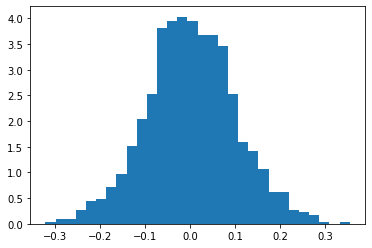

In [2]:


mu_rc    = 0         ## zero mean
sigma_rc = 0.1       ## standard deviation

s_rc = np.random.normal(mu_rc, sigma_rc, 1000)

## verify the mean and variance

print(  abs(mu_rc     -  np.mean(s_rc))  )
print(  abs(sigma_rc  -  np.std(s_rc, ddof=1)))


## Display the histogram of the samples, and the PDF function

count, bins, ignored = plt.hist(s_rc, 30, density=True)

print(count)
print(bins)
print(bins.shape)


In [3]:

def gaussian_pdf(x):
    return 1/(sigma_rc * np.sqrt(2 * np.pi)) * np.exp( - (x - mu_rc)**2 / (2 * sigma_rc**2))


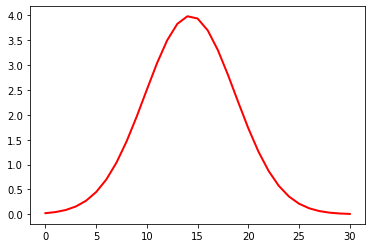

In [4]:

plt.plot(gaussian_pdf(bins), linewidth=2, color='r')


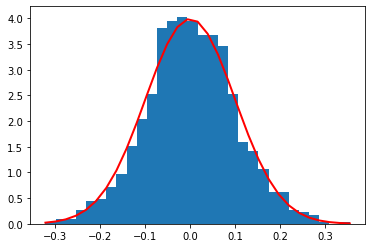

In [5]:

count, bins, ignored = plt.hist(s_rc, 30, density=True)
plt.plot(bins, gaussian_pdf(bins), linewidth=2, color='r')
plt.show()


## Functions for data with quadratic shape and Normally distributed error

In [6]:

###############################################################
## quadratic function

def f(x):
    return x**2-6*x+9 

###############################################################
## This function generates quadratic data perturbed with error
## which follows a normal distribution
## the sigma*x is what increases the standard deviation of the 
## error proportionally as x grows


def data_generator(x, sigma_0, samples):
    ##                      mean     standard dev      
    return np.random.normal(f(x),    sigma_0*x,     samples)

###############################################################


## Data x for quadratic curve

In [7]:

x_vals = np.arange(1, 5.2, 0.2)
print(x_vals)


[1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8 3.  3.2 3.4 3.6 3.8 4.  4.2 4.4
 4.6 4.8 5. ]


## Data points from g(x) for scatter

The g(x) function is made up of f(x) and the error. This process is done in the following for loop. 

$  \large g(x) = f(x) + \epsilon  $

In [8]:


x_arr = np.array([])
y_arr = np.array([])


for x in x_vals:
    ## for every sample in x_vals, generate n=50 normally distributed
    ## samples for y_arr
    x_arr = np.append(    x_arr,   np.full(samples, x)                       )
    y_arr = np.append(    y_arr,   data_generator(x, sigma_0, samples)       )

    
x_arr, y_arr   =   shuffle(x_arr, y_arr)

print(x_arr)
print(y_arr)
print(x_arr.shape)
print(y_arr.shape)



[3.  4.4 1.2 ... 2.6 3.8 3.2]
[-0.57475613  1.70130185  3.11191605 ...  0.20169545  0.42908219
 -0.13036368]
(1050,)
(1050,)


## Plot the g(x) function



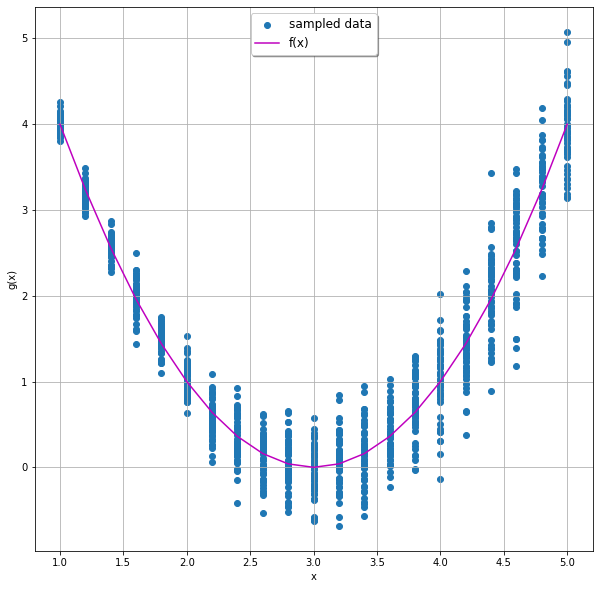

In [9]:
fig, ax = plt.subplots(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('g(x)')

ax.scatter(x_arr,y_arr,label='sampled data')

ax.plot( x_vals, list(map(f,x_vals)), c='m', label='f(x)')

ax.legend(loc='upper center',fontsize='large',shadow=True)
plt.show()

## Convert train data to pyTorch

In [10]:


inputs  = x_arr
targets = y_arr

## make into column vectors
inputs  = inputs.reshape((-1, 1))
targets = targets.reshape((-1, 1))

## fix data type
inputs  = inputs.astype(np.float32)
targets = targets.astype(np.float32)

## convert to torch tensors
inputs  = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)

print(inputs)
print(targets)



tensor([[3.0000],
        [4.4000],
        [1.2000],
        ...,
        [2.6000],
        [3.8000],
        [3.2000]])
tensor([[-0.5748],
        [ 1.7013],
        [ 3.1119],
        ...,
        [ 0.2017],
        [ 0.4291],
        [-0.1304]])


## Create Torch DataLoader

In [11]:
#####################################################################
## define dataset

train_ds = TensorDataset(inputs, targets)

print(  train_ds[0:3]  )
    
#####################################################################
## define dataloader

train_dl = DataLoader(train_ds, batch_size, shuffle=True)

print(    next(iter(train_dl))   )


####################################################################

(tensor([[3.0000],
        [4.4000],
        [1.2000]]), tensor([[-0.5748],
        [ 1.7013],
        [ 3.1119]]))
[tensor([[2.0000],
        [3.6000],
        [2.6000],
        [4.8000],
        [3.0000]]), tensor([[ 1.3344],
        [-0.1140],
        [ 0.3554],
        [ 3.3284],
        [ 0.2333]])]


## Fit a deep learning regression network to the g(x) data

In [12]:

#####################################################################

def fit(num_epochs, model, loss_fn, opt):
    for epoch in range(num_epochs):
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
    print('Training loss:', loss_fn(model(inputs), targets))
    

#####################################################################
## starts fitting after 1000 iterations
## use Tanh or sigmoid ?? 

class DL_Net(nn.Module):
    ## initialize the layers
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(1, 12)
        self.act1    = nn.Tanh()             ## nn.ReLU()
        self.linear2 = nn.Linear(12, 12)
        self.act2    = nn.Tanh() 
        self.linear3 = nn.Linear(12, 1)
         
    
    ## perform inference
    def forward(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        x = self.act2(x)
        x = self.linear3(x)
        return x
    
#######################################################
## Does not fit using ReLU! Why ??

class SimpleNet(nn.Module):
    ## initialize the layers
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(1, 12)
        self.act1    = nn.Tanh()
        self.linear2 = nn.Linear(12, 1)
    
    ## perform inference
    def forward(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        return x
    
    
#############################################################

model   = DL_Net()    ## 5000 epochs to get a better fit
## model   = SimpleNet()
## opt     = torch.optim.SGD(   model.parameters(), lr=learning_rate   )
opt        = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn = F.mse_loss

#############################################################

fit(N_EPOCHS, model, loss_fn, opt)

preds = model(inputs)

print(preds)
print(targets)

#############################################################



Training loss: tensor(0.2325, grad_fn=<MseLossBackward0>)
tensor([[ 0.1372],
        [ 2.0576],
        [ 3.4560],
        ...,
        [-0.0147],
        [ 1.1394],
        [ 0.3286]], grad_fn=<AddmmBackward0>)
tensor([[-0.5748],
        [ 1.7013],
        [ 3.1119],
        ...,
        [ 0.2017],
        [ 0.4291],
        [-0.1304]])


## Generate Test x data, and use model to predict

In [13]:

x_test_orig         =   np.arange( 1.1, 5.1, 0.2)

'''

x_test_oversampled = np.array([])

for x in x_test_orig:
    ## for every sample in x_test_orig, generate n=50 copies
    x_test_oversampled = np.append(    x_test_oversampled,   np.full(samples, x)                       )

print(x_test_oversampled.shape)

'''

x_test = x_test_orig

x_test  = x_test.reshape((-1, 1))
x_test  = x_test.astype(np.float32)
x_test  = torch.from_numpy(x_test)

print(x_test)



tensor([[1.1000],
        [1.3000],
        [1.5000],
        [1.7000],
        [1.9000],
        [2.1000],
        [2.3000],
        [2.5000],
        [2.7000],
        [2.9000],
        [3.1000],
        [3.3000],
        [3.5000],
        [3.7000],
        [3.9000],
        [4.1000],
        [4.3000],
        [4.5000],
        [4.7000],
        [4.9000]])


## Use model to predict on test data

In [14]:

y_pred  = model(x_test)

print(y_pred)
print(targets)



tensor([[ 3.8004],
        [ 3.0897],
        [ 2.3275],
        [ 1.5938],
        [ 0.9637],
        [ 0.4848],
        [ 0.1715],
        [ 0.0133],
        [-0.0131],
        [ 0.0660],
        [ 0.2255],
        [ 0.4440],
        [ 0.7036],
        [ 0.9899],
        [ 1.2915],
        [ 1.5994],
        [ 1.9063],
        [ 2.2068],
        [ 2.4969],
        [ 2.7736]], grad_fn=<AddmmBackward0>)
tensor([[-0.5748],
        [ 1.7013],
        [ 3.1119],
        ...,
        [ 0.2017],
        [ 0.4291],
        [-0.1304]])


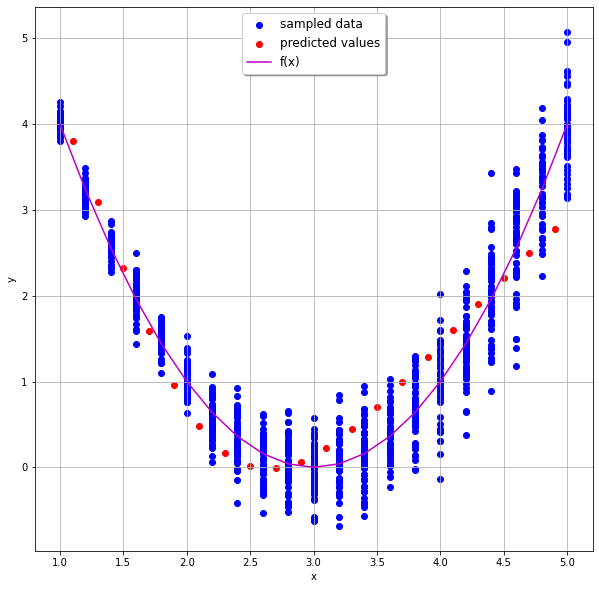

In [15]:


fig, ax = plt.subplots(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')

ax.scatter(x_arr,y_arr,c='b',label='sampled data')

ax.scatter(x_test.detach().numpy() ,y_pred.detach().numpy() ,c='r',label='predicted values')

ax.plot(x_vals,list(map(f,x_vals)),c='m',label='f(x)')

ax.legend(loc='upper center',fontsize='large',shadow=True)
plt.show()



From the red dots, it seems our Neural Net only learned the f(x) part of g(x) and it completely ignored the $ \large \epsilon $ error normally distributed random variable. To convince yourself, try more test samples (> 1000) and it will always plot about the same set of red dots.

To address this issue Christopher Bishop proposed MDNs. 

## Now repeat with an MDN

In [22]:
#####################################################################


class MDN_Net(nn.Module):
    ## initialize the layers
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(1, 12)
        self.act1    = nn.Tanh()             
        self.linear2 = nn.Linear(12, 12)
        self.act2    = nn.Tanh() 
        self.mu      = nn.Linear(12, 1)
        self.sigma   = nn.Linear(12, 1)
        ## self.act_sig = lambda x: nn.ELU(x) + 1         ## gets rid of negative vals
         
    
    ## perform inference
    def forward(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        x = self.act2(x)
        x_mu    = self.mu(x)
        x_sigma = self.sigma(x)
        ## x_sigma = self.act_sig(x_sigma)
        ## e^x always positive which is required here for sigma
        x_sigma = torch.exp(x_sigma)                  
        return x_mu, x_sigma
    
######################################################################
    
'''

## scratch equations MDN loss

# Define Loss function

cte = 1.0 / np.sqrt(2.0 * np.pi)


def gaussian_distribution(y, mu, sigma):

    result = (y.expand_as(mu) - mu) * torch.reciprocal(sigma)
    result = -0.5 * (result * result)
    return (torch.exp(result) * torch.reciprocal(sigma)) * cte


def mdn_loss_fn(w, sigma, mu, y):

    result = gaussian_distribution(y, mu, sigma) * w
    result = torch.sum(result, dim=1)
    result = -torch.log(result)
    return torch.mean(result)


'''
    
    
######################################################################

def mdn_loss(mu, sigma, y):
    dist = torch.distributions.Normal(loc=mu, scale=sigma)
    return torch.mean(-dist.log_prob(y))

######################################################################

def mdn_fit(num_epochs, model, loss_fn, opt):
    for epoch in range(num_epochs):
        for xb, yb in train_dl:
            pred_mu, pred_sigma = model(xb)
            loss = loss_fn(pred_mu, pred_sigma, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
    pred_mu, pred_sigma = model(inputs)
    print('Training loss:', loss_fn(pred_mu, pred_sigma, targets))


######################################################################

model   = MDN_Net()    ## 5000 epochs to get a better fit
opt     = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn = mdn_loss

######################################################################

mdn_fit(N_EPOCHS, model, loss_fn, opt)

pred_mu, pred_sigma = model(inputs)

print(pred_mu)
print(pred_sigma)





Training loss: tensor(0.5454, grad_fn=<MeanBackward0>)
tensor([[0.1290],
        [1.2432],
        [3.0803],
        ...,
        [0.1610],
        [0.6614],
        [0.2085]], grad_fn=<AddmmBackward0>)
tensor([[0.2656],
        [0.9492],
        [0.4086],
        ...,
        [0.2181],
        [0.5237],
        [0.3064]], grad_fn=<ExpBackward0>)


## Test MDN on test set

In [33]:

pred_mu, pred_sigma = model(x_test)

print(pred_mu)
print(pred_sigma)


tensor([[3.3115],
        [2.8311],
        [2.2896],
        [1.7236],
        [1.1907],
        [0.7479],
        [0.4249],
        [0.2220],
        [0.1236],
        [0.1100],
        [0.1625],
        [0.2653],
        [0.4052],
        [0.5714],
        [0.7548],
        [0.9480],
        [1.1449],
        [1.3407],
        [1.5317],
        [1.7150]], grad_fn=<AddmmBackward0>)
tensor([[0.4472],
        [0.3728],
        [0.3113],
        [0.2647],
        [0.2329],
        [0.2147],
        [0.2084],
        [0.2124],
        [0.2261],
        [0.2498],
        [0.2844],
        [0.3319],
        [0.3945],
        [0.4754],
        [0.5777],
        [0.7050],
        [0.8602],
        [1.0461],
        [1.2643],
        [1.5153]], grad_fn=<ExpBackward0>)


[[1.1 1.3 1.5 1.7 1.9 2.1 2.3 2.5 2.7 2.9 3.1 3.3 3.5 3.7 3.9 4.1 4.3 4.5
  4.7 4.9]]
[3.311545, 2.831071, 2.2896192, 1.7236145, 1.1907382, 0.7478632, 0.4248528, 0.22199892, 0.12364051, 0.10998517, 0.16248438, 0.26529008, 0.4052269, 0.5713949, 0.7547807, 0.94795835, 1.1448777, 1.3406997, 1.5316694, 1.7149868]
[0.44715017, 0.37283313, 0.3113329, 0.26468647, 0.23289222, 0.21470633, 0.20836379, 0.21239316, 0.22611895, 0.2497708, 0.2844139, 0.3318505, 0.39452034, 0.47537965, 0.5777263, 0.70495224, 0.8602278, 1.0461396, 1.2643461, 1.5152993]
[0.1, 0.12, 0.13999999999999999, 0.16, 0.18, 0.19999999999999998, 0.21999999999999997, 0.23999999999999996, 0.25999999999999995, 0.27999999999999997, 0.3, 0.31999999999999995, 0.33999999999999997, 0.36, 0.37999999999999995, 0.3999999999999999, 0.41999999999999993, 0.43999999999999995, 0.45999999999999996, 0.4799999999999999, 0.49999999999999994]


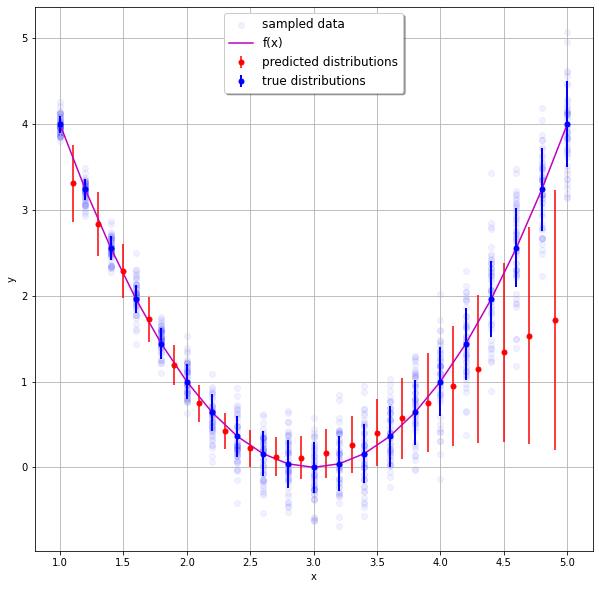

In [47]:
## print(x_test.detach().numpy().reshape((1, -1)))
## print(list(pred_mu.detach().numpy().reshape((1, -1))[0]))
## print( list(  np.absolute(   pred_sigma.detach().numpy().reshape((1, -1))[0]   )   ) )
## print(list(map(lambda x: sigma_0*x, x_vals)))

fig, ax = plt.subplots(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')


ax.errorbar(x_test.detach().numpy().reshape((1, -1))[0], 
            list(pred_mu.detach().numpy().reshape((1, -1))[0]), 
            yerr=list(    np.absolute(   pred_sigma.detach().numpy().reshape((1, -1))[0]    )       ),
            c='r',
            ls='None',
            marker='.',
            ms=10,
            label='predicted distributions'
)
                                    
ax.scatter(x_arr,y_arr,c='b',alpha=0.05,label='sampled data')

ax.errorbar(x_vals,
            list(map(f,x_vals)),
            yerr=list(map(lambda x: sigma_0*x, x_vals)),
            c='b',
            lw=2,
            ls='None',
            marker='.',
            ms=10,
            label='true distributions'
)
                                


ax.plot(x_vals,list(map(f,x_vals)),c='m',label='f(x)')


ax.legend(loc='upper center',fontsize='large',shadow=True)
plt.show()


